# Week 1 Project: Teeth Classification - Preprocessing, Visualization, and Model Training


In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch
import seaborn as sns
from collections import Counter
import os
from PIL import Image
import random
import torch.nn as nn
import torch.nn.functional as F
import time
from sklearn.utils.class_weight import compute_class_weight

## 🧪 Data Augmentation

In [2]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], 
                         [0.5, 0.5, 0.5])  
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], 
                         [0.5, 0.5, 0.5])
])

In [120]:
data_dir = "/kaggle/input/teeth-dataset/Teeth_Dataset"
train_dataset = datasets.ImageFolder(root=f"{data_dir}/Training", transform=train_transform)
val_dataset   = datasets.ImageFolder(root=f"{data_dir}/Validation", transform=val_test_transform)
test_dataset  = datasets.ImageFolder(root=f"{data_dir}/Testing", transform=val_test_transform)

# Create DataLoaders


In [35]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [36]:
class_names = train_dataset.classes
print("Classes:", class_names,'=======>Number of classes:',len(class_names))

Classes: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT'] =======>Number of classes: 7


In [121]:
class_names = test_dataset.classes
print("Classes:", class_names,'=======>Number of classes:',len(class_names))

Classes: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT', 'out', 'output', 'outputs'] =======>Number of classes: 10


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/tmp/ipykernel_35/1323160689.py:12: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


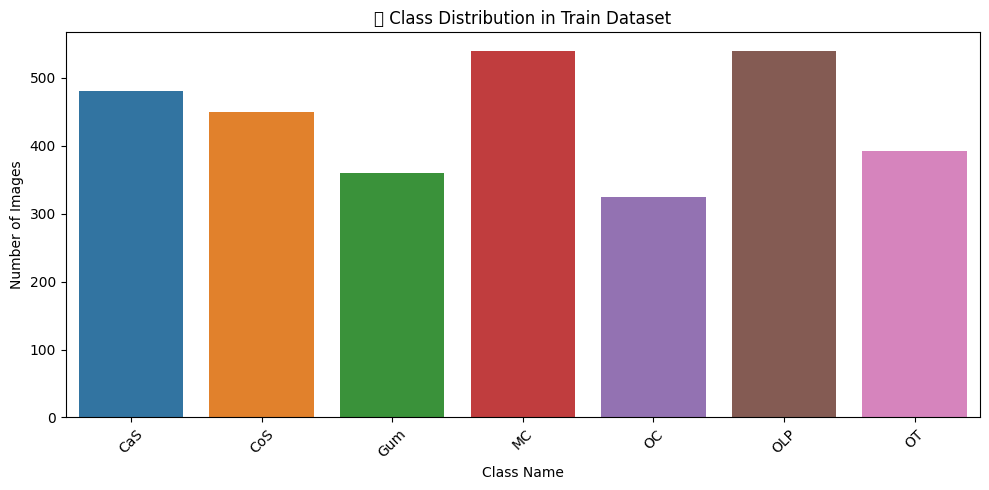

In [18]:
labels = [label for _, label in train_dataset.samples]
label_counts = Counter(labels)
class_names = train_dataset.classes
counts_per_class = {class_names[i]: count for i, count in label_counts.items()}

plt.figure(figsize=(10, 5))
sns.barplot(x=list(counts_per_class.keys()), y=list(counts_per_class.values()))
plt.title("📊 Class Distribution in Train Dataset")
plt.xlabel("Class Name")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# filter test data

In [39]:
allowed_classes = ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT'] 
filtered_samples = [
    (path, label)
    for path, label in test_dataset.samples
    if test_dataset.classes[label] in allowed_classes]
test_dataset.samples = filtered_samples
test_dataset.targets = [label for _, label in filtered_samples]
new_class_to_idx = {cls: i for i, cls in enumerate(allowed_classes)}
test_dataset.class_to_idx = new_class_to_idx
test_dataset.classes = allowed_classes


In [40]:
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [21]:
raw_dataset = datasets.ImageFolder(root=f"{data_dir}/Training")

/tmp/ipykernel_35/3308400573.py:20: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from current font.
  plt.tight_layout()


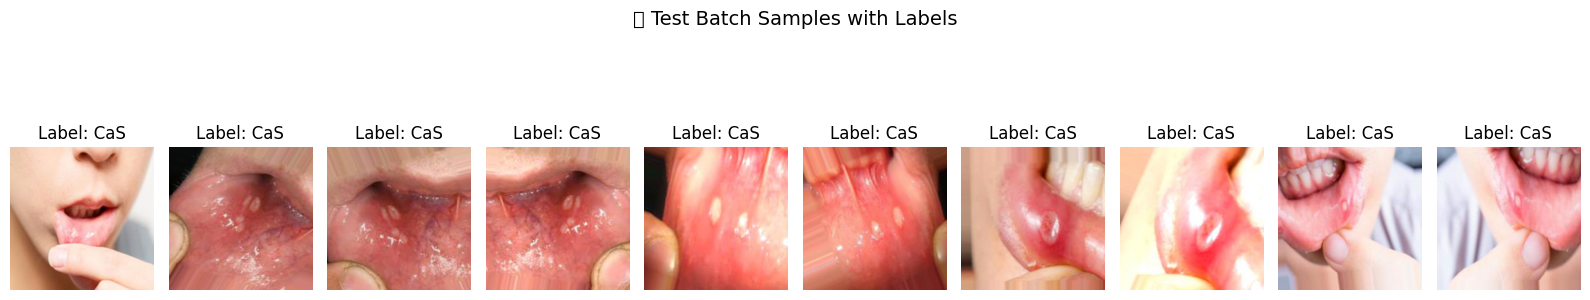

In [44]:
def show_batch_from_loader(dataloader, class_names, num_images=8):
    model.eval()
    for images, labels in dataloader:
        images = images[:num_images]  
        labels = labels[:num_images]
        break
    unnorm = transforms.Normalize(mean=[-1, -1, -1], std=[2, 2, 2])

    plt.figure(figsize=(16, 4))
    for i in range(num_images):
        img = unnorm(images[i]).permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"Label: {class_names[labels[i]]}")
        plt.axis('off')

    plt.suptitle("🖼️ Test Batch Samples with Labels", fontsize=14)
    plt.tight_layout()
    plt.show()
show_batch_from_loader(test_loader, class_names, num_images=10)


In [108]:
class TeethCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(TeethCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)


        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)

        self.fc1 = nn.Linear(256 * 14 * 14, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 32, 112, 112]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 64, 56, 56]
        x = self.pool(F.relu(self.conv3(x)))  # [B, 128, 28, 28]
        x = self.pool(F.relu(self.conv4(x)))
        
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [109]:
model = TeethCNN(num_classes=len(class_names))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

TeethCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=50176, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=7, bias=True)
)

In [110]:
labels = [label for _, label in train_dataset.samples]
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class weights:", class_weights_tensor)


Class weights: tensor([0.9187, 0.9800, 1.2250, 0.8167, 1.3611, 0.8167, 1.1221],
       device='cuda:0')


In [111]:
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [72]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    train_loss_history = []
    val_loss_history = []
    val_acc_history = []
    train_acc_history = []  

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0  
        total_train = 0   

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_acc = correct_train / total_train

        train_loss_history.append(epoch_loss)
        train_acc_history.append(train_acc)

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        val_loss = 0.0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = correct_val / total_val

        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {epoch_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history


In [73]:
def plot_metrics(train_loss, val_loss, train_acc, val_acc):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="Train Accuracy", color='blue')
    plt.plot(epochs, val_acc, label="Val Accuracy", color='green')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [74]:
def evaluate_on_test(model, test_loader, device, class_names):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    acc = correct / total
    print(f"✅ Test Accuracy: {acc:.4f}")

    # التصنيف المفصل (لو عاوز)
    from sklearn.metrics import classification_report, confusion_matrix
    print(classification_report(all_labels, all_preds, target_names=class_names))


# model training

In [112]:
train_loss, val_loss, train_acc, val_acc = train_model(
    model,
    train_loader,
    val_loader,
    criterion, 
    optimizer,
    device,
    num_epochs=50
)

Epoch [1/50] | Train Loss: 1.8725 | Train Acc: 0.2306 | Val Loss: 1.7838 | Val Acc: 0.2568
Epoch [2/50] | Train Loss: 1.6831 | Train Acc: 0.3346 | Val Loss: 1.6571 | Val Acc: 0.3375
Epoch [3/50] | Train Loss: 1.5185 | Train Acc: 0.4062 | Val Loss: 1.5115 | Val Acc: 0.4047
Epoch [4/50] | Train Loss: 1.3839 | Train Acc: 0.4593 | Val Loss: 1.3774 | Val Acc: 0.4767
Epoch [5/50] | Train Loss: 1.3232 | Train Acc: 0.4917 | Val Loss: 1.1950 | Val Acc: 0.5778
Epoch [6/50] | Train Loss: 1.1963 | Train Acc: 0.5429 | Val Loss: 1.1583 | Val Acc: 0.5739
Epoch [7/50] | Train Loss: 1.0842 | Train Acc: 0.5925 | Val Loss: 0.9680 | Val Acc: 0.6595
Epoch [8/50] | Train Loss: 1.0006 | Train Acc: 0.6239 | Val Loss: 0.9175 | Val Acc: 0.6702
Epoch [9/50] | Train Loss: 0.9224 | Train Acc: 0.6628 | Val Loss: 0.9243 | Val Acc: 0.6722
Epoch [10/50] | Train Loss: 0.8737 | Train Acc: 0.6887 | Val Loss: 0.7531 | Val Acc: 0.7218
Epoch [11/50] | Train Loss: 0.7831 | Train Acc: 0.7195 | Val Loss: 0.6968 | Val Acc: 0.75

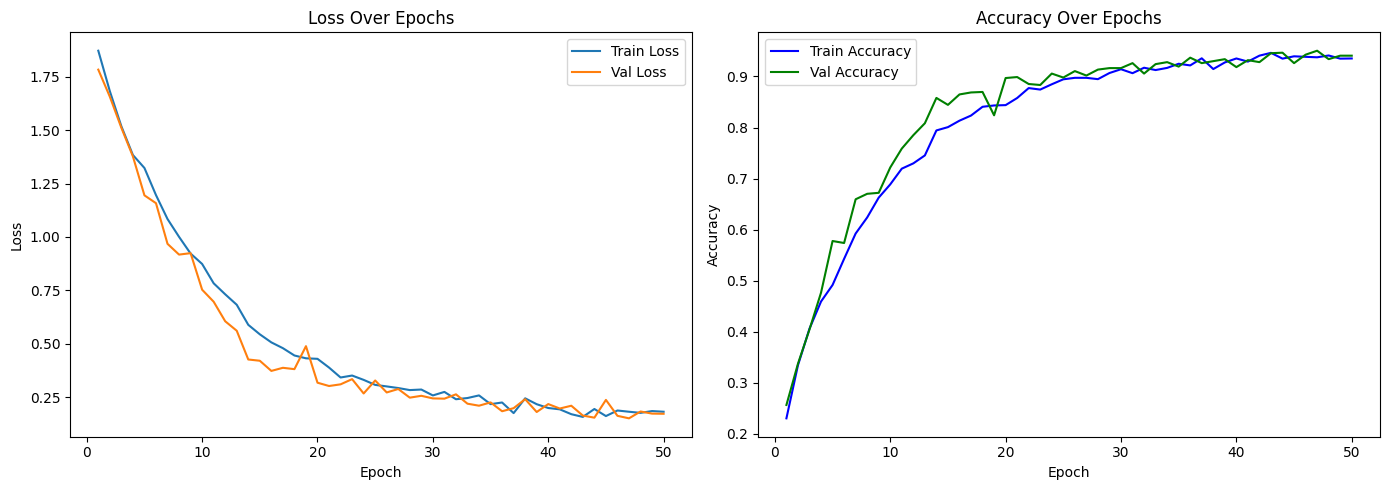

In [114]:
plot_metrics(train_loss, val_loss, train_acc, val_acc)

# final eval on test data

In [115]:
evaluate_on_test(model, test_loader, device, class_names)

✅ Test Accuracy: 0.9290
              precision    recall  f1-score   support

         CaS       0.94      0.93      0.93       160
         CoS       0.93      0.97      0.95       149
         Gum       0.93      0.93      0.93       120
          MC       0.96      0.91      0.94       180
          OC       0.94      0.92      0.93       108
         OLP       0.91      0.91      0.91       180
          OT       0.89      0.95      0.92       131

    accuracy                           0.93      1028
   macro avg       0.93      0.93      0.93      1028
weighted avg       0.93      0.93      0.93      1028



## 🔍 Grad-CAM: Visualizing Model Decisions

**Grad-CAM (Gradient-weighted Class Activation Mapping)** is a powerful interpretability technique used in computer vision to visualize the regions of an input image that a convolutional neural network focuses on when making predictions.

---

### 🎯 Objective:
To understand **why** the model made a certain prediction by highlighting **discriminative regions** in the image that most influenced the output.

---

### 🛠️ How It Works:

1. **Forward Pass**: Pass the image through the model and get the feature maps from a selected convolutional layer.
2. **Backward Pass**: Compute the gradients of the target class score with respect to those feature maps.
3. **Weighting**: Average the gradients over spatial dimensions to obtain importance weights.
4. **Weighted Sum**: Multiply the weights with the feature maps and sum them up to get the class activation map.
5. **ReLU + Resize**: Apply ReLU and resize the map to the input image size.

---

### 📌 Use Cases:
- Debugging and validating CNN models.
- Visual explanation for model decisions.
- Identifying dataset bias or label issues.

---



In [116]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()
        
    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        self.model.eval()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        loss = output[:, class_idx]
        self.model.zero_grad()
        loss.backward()

        gradients = self.gradients[0]         # [C, H, W] (GPU)
        activations = self.activations[0]     # [C, H, W] (GPU)
        weights = gradients.mean(dim=(1, 2))  # GAP

        cam = torch.zeros(activations.shape[1:], device=activations.device)
        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / cam.max()
        return cam.detach().cpu().numpy()


In [153]:
def predict_with_gradcam_multiple_layers(model, dataloader, class_names, target_layers, img_idx):
    model.eval()

    # Get one image
    with torch.no_grad():
        for inputs, labels in dataloader:
            image_tensor = inputs[img_idx].unsqueeze(0).to(device)
            actual_class_idx = labels[img_idx].item()
            break

    # Prediction
    output = model(image_tensor)
    pred_class_idx = output.argmax(dim=1).item()
    pred_class_name = class_names[pred_class_idx]
    actual_class_name = class_names[actual_class_idx]

    print(f"✅ Actual class   : {actual_class_name} (Index: {actual_class_idx})")
    print(f"🧠 Predicted class: {pred_class_name} (Index: {pred_class_idx})")

    # Unnormalize image
    unnorm = transforms.Normalize(mean=[-1, -1, -1], std=[2, 2, 2])
    image_for_vis = unnorm(image_tensor[0].cpu()).permute(1, 2, 0).numpy()
    image_for_vis = np.clip(image_for_vis, 0, 1)

    import cv2
    plt.figure(figsize=(5 * (len(target_layers) + 1), 4))

    # Original image
    plt.subplot(1, len(target_layers) + 1, 1)
    plt.imshow(image_for_vis)
    plt.title(f"Original\nActual: {actual_class_name}")
    plt.axis('off')

    # Grad-CAM for each layer
    for i, layer in enumerate(target_layers):
        gradcam = GradCAM(model, layer)
        cam = gradcam.generate(image_tensor)
        cam_resized = cv2.resize(cam, (224, 224))

        plt.subplot(1, len(target_layers) + 1, i + 2)
        plt.imshow(image_for_vis)
        plt.imshow(cam_resized, cmap='jet', alpha=0.5)
        layer_name = [name for name, module in model.named_modules() if module == layer][0]
        plt.title(f"Grad-CAM\nLayer: {layer_name}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


✅ Actual class   : CaS (Index: 0)
🧠 Predicted class: CaS (Index: 0)


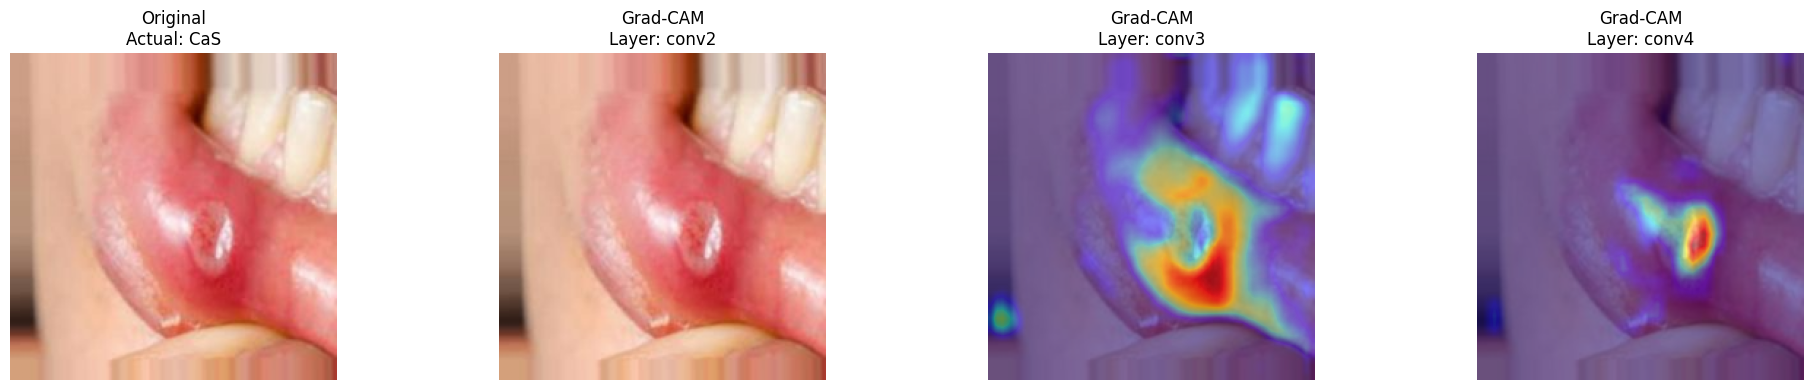

In [154]:

predict_with_gradcam_multiple_layers(
    model=model,
    dataloader=test_loader,
    class_names=class_names,
    target_layers=[model.conv2, model.conv3, model.conv4],
    img_idx=6
)


In [ ]:
torch.save(model, "teeth_model_full.pth")